In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
from xgcm import Grid

In [2]:
def open_IC():
    IC = xr.open_dataset('ISOMIP_IC.nc')
    return IC


In [3]:
IC = open_IC()
IC.h

<xarray.DataArray 'h' (Time: 1, Layer: 25, lath: 40, lonh: 240)>
[240000 values with dtype=float64]
Coordinates:
  * lath     (lath) float64 1.0 3.0 5.0 7.0 9.0 ... 71.0 73.0 75.0 77.0 79.0
  * lonh     (lonh) float64 321.0 323.0 325.0 327.0 ... 793.0 795.0 797.0 799.0
  * Layer    (Layer) float64 1.027e+03 1.027e+03 ... 1.028e+03 1.028e+03
  * Time     (Time) timedelta64[ns] 00:00:00
Attributes:
    long_name:  Layer Thickness
    units:      m
    checksum:   68D939500A45369D

In [4]:
!pwd

/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/layer-melton


In [5]:
ave = False ## True means use 5 daily average rather than hourly prog
basee = '/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/'
def open_files(folder):
    base = basee + folder
    if ave:
        prog = xr.open_dataset(base + '/ave_prog.nc')
    else:
        prog = xr.open_dataset(base + '/prog.nc')
    ocean_static = xr.open_dataset(base + "/ocean_geometry.nc")
    return prog, ocean_static
def open_IC(folder):
    base = basee + folder
    IC = xr.open_dataset(base + '/ISOMIP_IC.nc')
    return IC
def open_Initialstate(folder):
    base = basee + folder
    IC = xr.open_dataset(base + '/Initial_state.nc')
    return IC

In [6]:
IC

<xarray.Dataset>
Dimensions:          (lath: 40, lonh: 240, latq: 41, lonq: 241, Layer: 25,
                      Interface: 26, Time: 1)
Coordinates:
  * lath             (lath) float64 1.0 3.0 5.0 7.0 9.0 ... 73.0 75.0 77.0 79.0
  * lonh             (lonh) float64 321.0 323.0 325.0 ... 795.0 797.0 799.0
  * latq             (latq) float64 0.0 2.0 4.0 6.0 8.0 ... 74.0 76.0 78.0 80.0
  * lonq             (lonq) float64 320.0 322.0 324.0 ... 796.0 798.0 800.0
  * Layer            (Layer) float64 1.027e+03 1.027e+03 ... 1.028e+03 1.028e+03
  * Interface        (Interface) float64 1.027e+03 1.027e+03 ... 1.028e+03
  * Time             (Time) timedelta64[ns] 00:00:00
Data variables: (12/20)
    Temp             (Time, Layer, lath, lonh) float64 ...
    Salt             (Time, Layer, lath, lonh) float64 ...
    h                (Time, Layer, lath, lonh) float64 ...
    u                (Time, Layer, lath, lonq) float64 ...
    v                (Time, Layer, latq, lonh) float64 ...
    frazil           (Time, lath, lonh) float64 ...
    ...               ...
    diffu            (Time, Layer, lath, lonq) float64 ...
    diffv            (Time, Layer, latq, lonh) float64 ...
    ubtav            (Time, lath, lonq) float64 ...
    vbtav            (Time, latq, lonh) float64 ...
    DTBT             (Time) timedelta64[ns] ...
    eta              (Time, Interface, lath, lonh) float64 ...
Attributes:
    filename:  ./ISOMIP_IC.nc

In [7]:
folder = 'layer'
plot_IC = False
def plot(ax,yy0,tt,i,variable,varname,vmin1,vmax1,cmap,ymax):
    prog, ocean_static = open_files(label)
    
    file_name = label
    if plot_IC == True:
        grid = Grid(IC,coords={"x":{"center":"lonh","outer":"lonq"},
                             "y":{"center":"lath","outer":"latq"},
                             "z":{"center":"Layer","outer":"Interface"}},periodic=False)
        depth = grid.interp(IC.eta,'x')
    else:
        grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
        depth = grid.interp(prog.e,'x')
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if varname == "uo": dataplot = dataplot[:,:,:,:-1]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) #Dummy, just for have z_levels
    # plot variable in colours
    xi, yyi = np.meshgrid(xx[yy0,:], yi) #We repeat the horizontal part of the grid by the number of zlevels
    #cax = ax.contourf(xi,yy[tt,...],dataplot[tt,:,yy0,:],levels = levels, cmap = cmap, extend = 'both',corner_mask = False)
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


In [33]:
label = 'layer-melton'

New


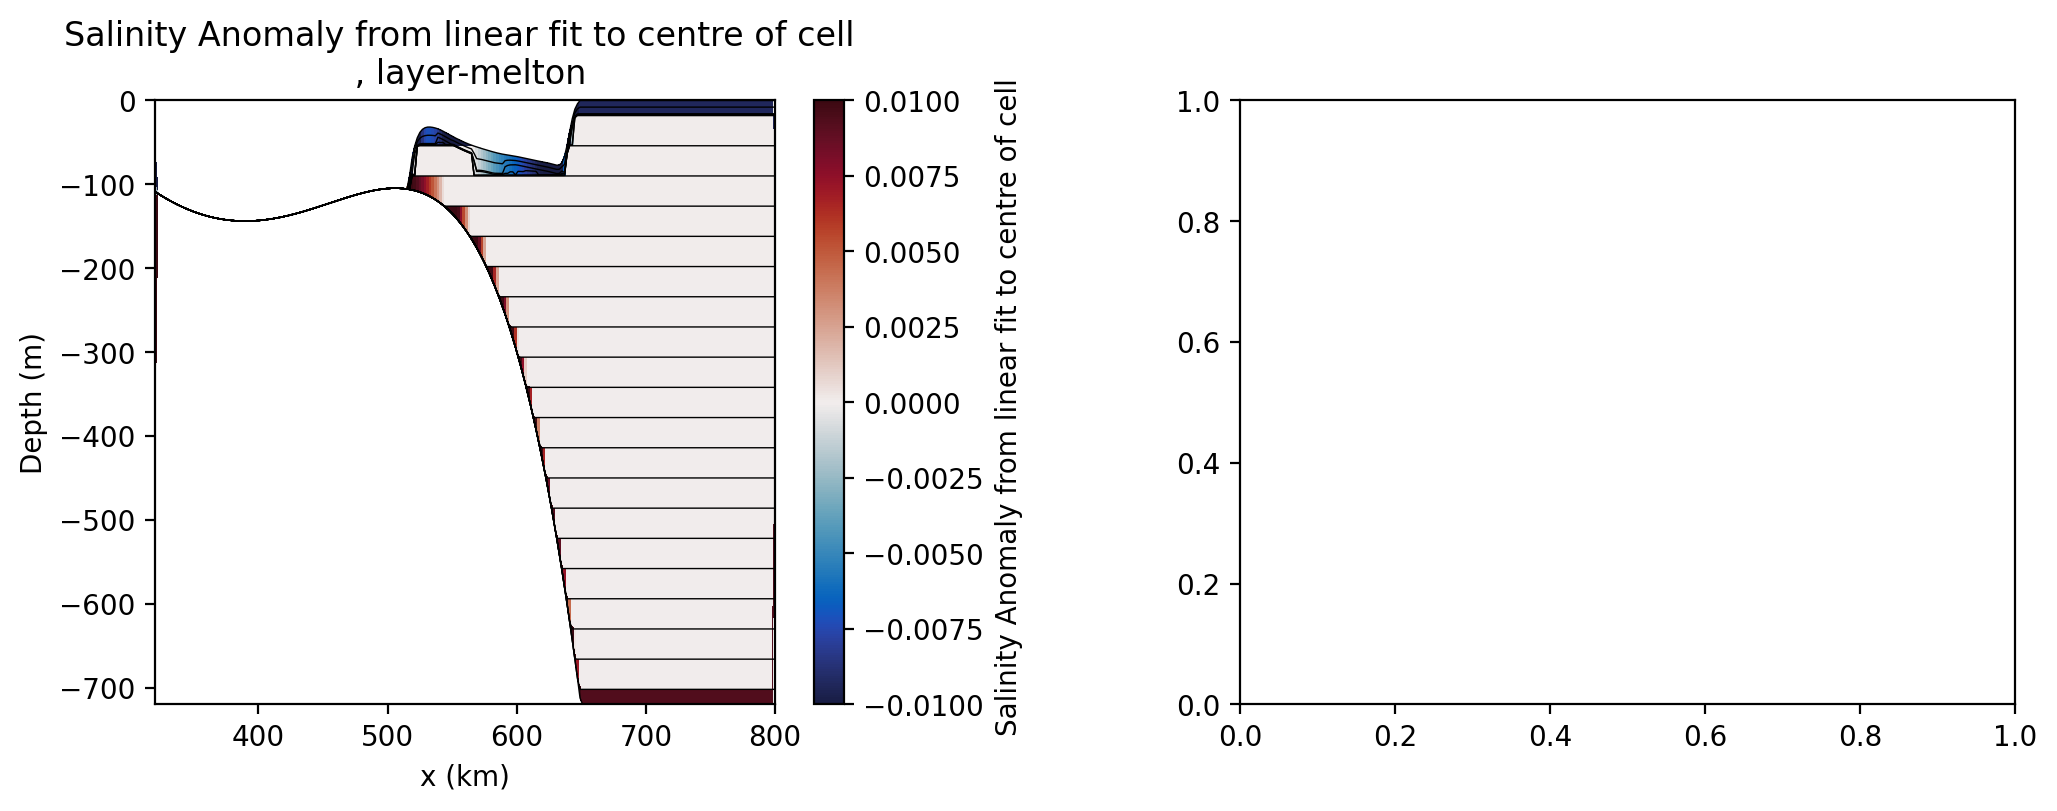

In [34]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,4),dpi = 200)
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = -1
time = 0
ymax = 720
print('New')
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
plot_IC = True
plot(axes[0],x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell \n",-0.01,0.01,cm.cm.balance,ymax)

# print('Old')
# label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile'
# prog, ocean_static = open_files(label)
# IC = open_IC(label)
# ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
# plot(axes[1],x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell \n",-0.01,0.01,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)

New


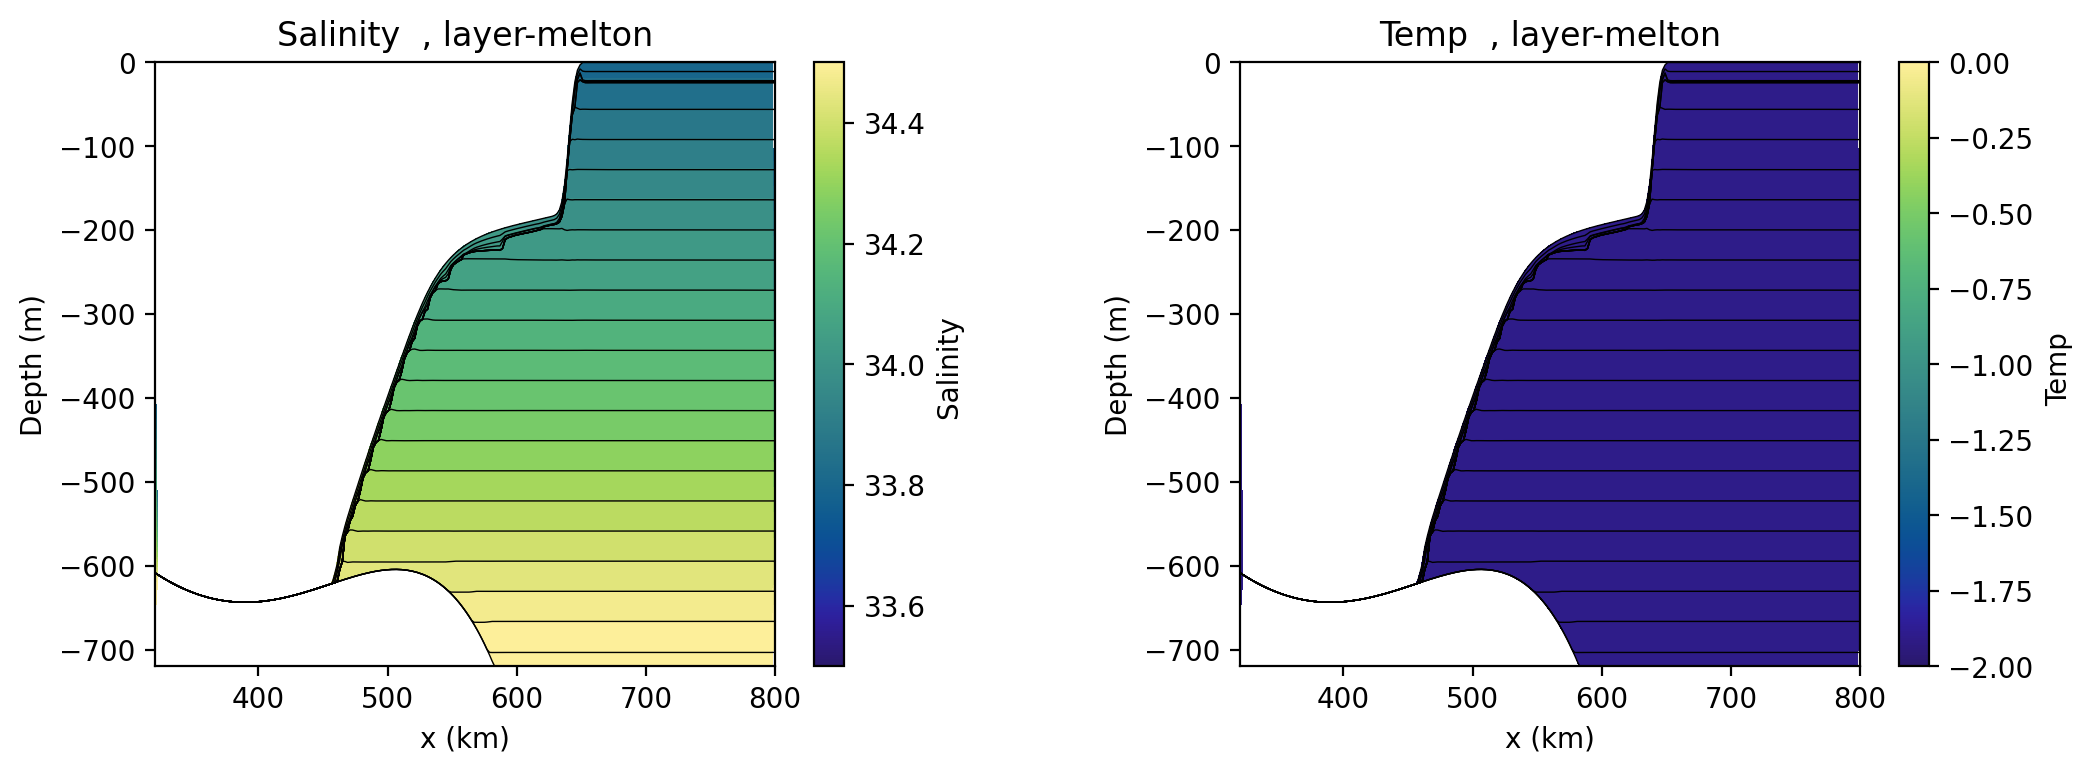

In [35]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,4),dpi = 200)
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = 20
time = -1
ymax = 720
print('New')
ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8

plot_IC = True

plot(axes[0],x,time,0,IC.Salt,"Salinity ",33.5,34.5,cm.cm.haline,ymax)
plot(axes[1],x,time,0,IC.Temp,"Temp ",-2,0,cm.cm.haline,ymax)

# print('Old')
# label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile'
# prog, ocean_static = open_files(label)
# IC = open_IC(label)
# ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
# plot(axes[1],x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell \n",-0.01,0.01,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)

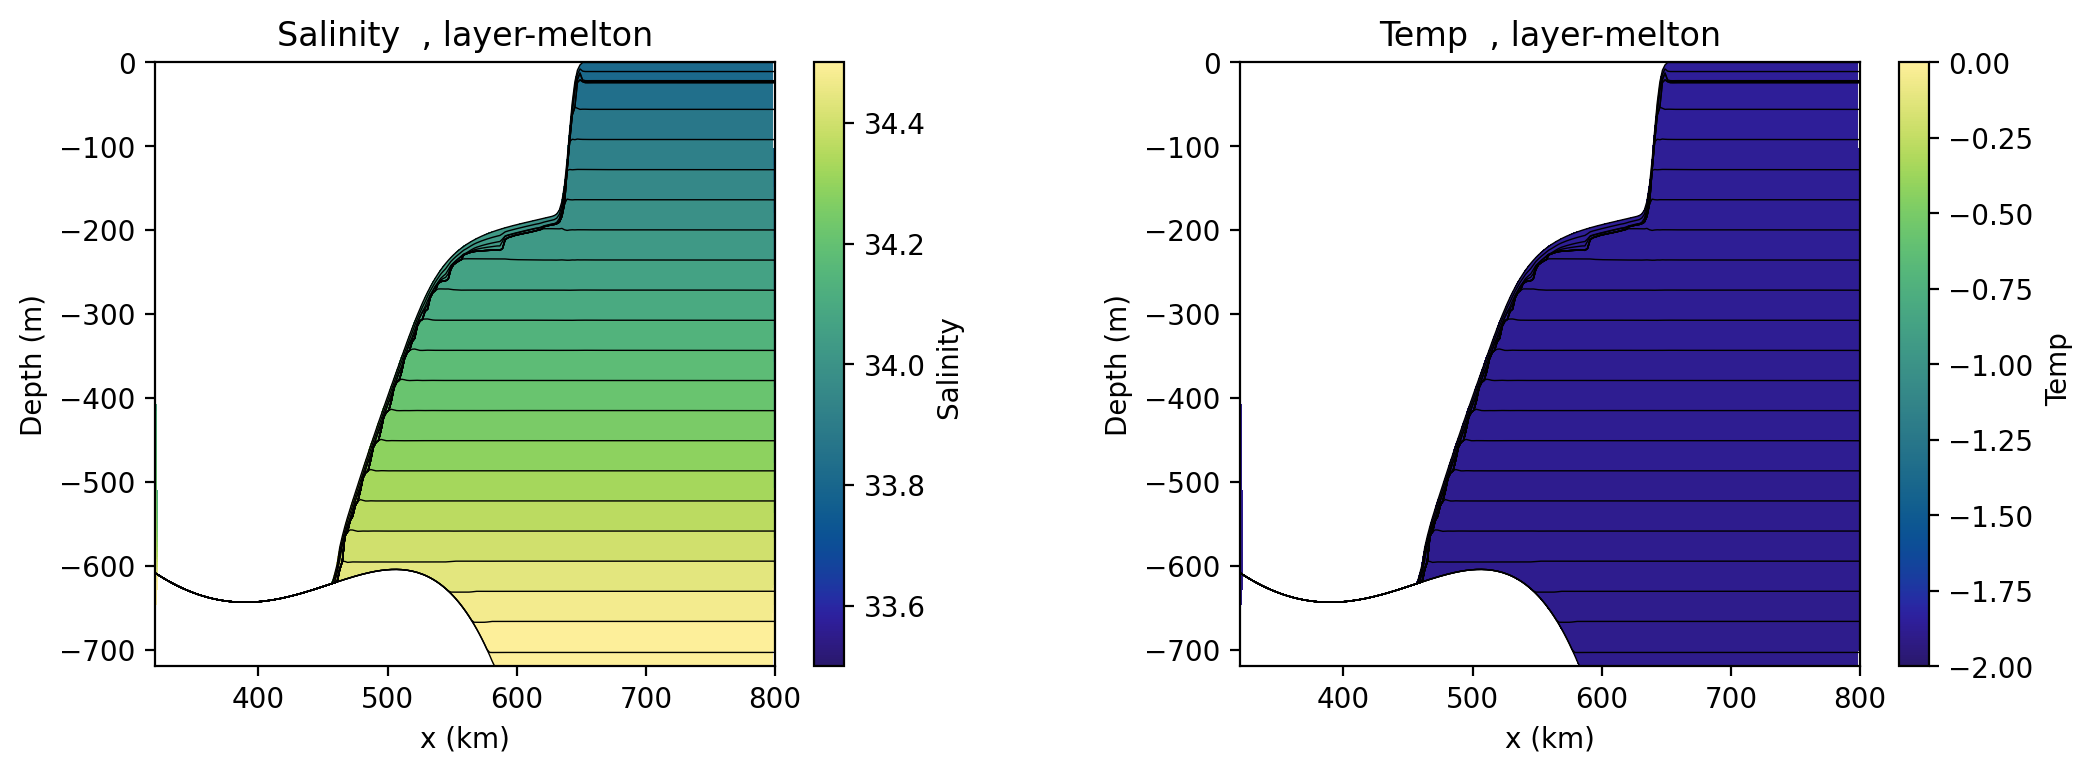

In [36]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,4),dpi = 200)
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = 20
time = -1
ymax = 720
plot_IC = False

plot(axes[0],x,time,0,prog.salt,"Salinity ",33.5,34.5,cm.cm.haline,ymax)
plot(axes[1],x,time,0,prog.temp,"Temp ",-2,0,cm.cm.haline,ymax)

# print('Old')
# label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile'
# prog, ocean_static = open_files(label)
# IC = open_IC(label)
# ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
# plot(axes[1],x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell \n",-0.01,0.01,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)

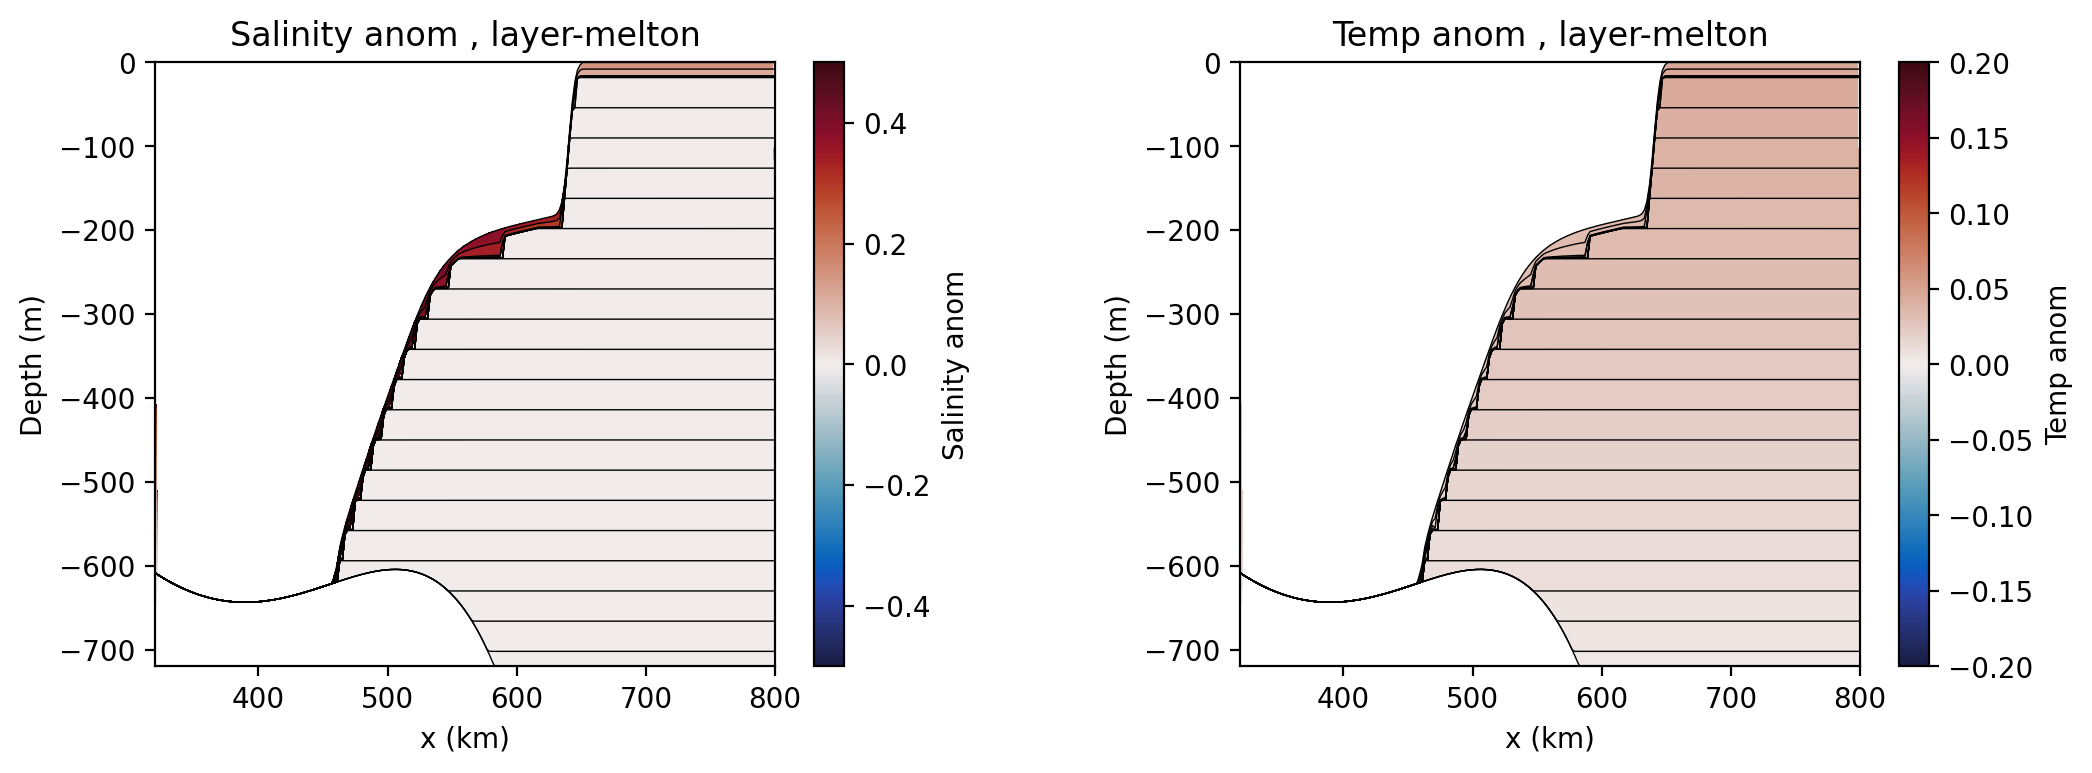

In [37]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,4),dpi = 200)
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = 20
time = 0
ymax = 720
plot_IC = False

plot(axes[0],x,time,0,prog.salt - IC.Salt.values,"Salinity anom",-0.5,0.5,cm.cm.balance,ymax)
plot(axes[1],x,time,0,prog.temp - IC.Temp.values,"Temp anom",-0.2,0.2,cm.cm.balance,ymax)

# print('Old')
# label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile'
# prog, ocean_static = open_files(label)
# IC = open_IC(label)
# ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
# plot(axes[1],x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell \n",-0.01,0.01,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)

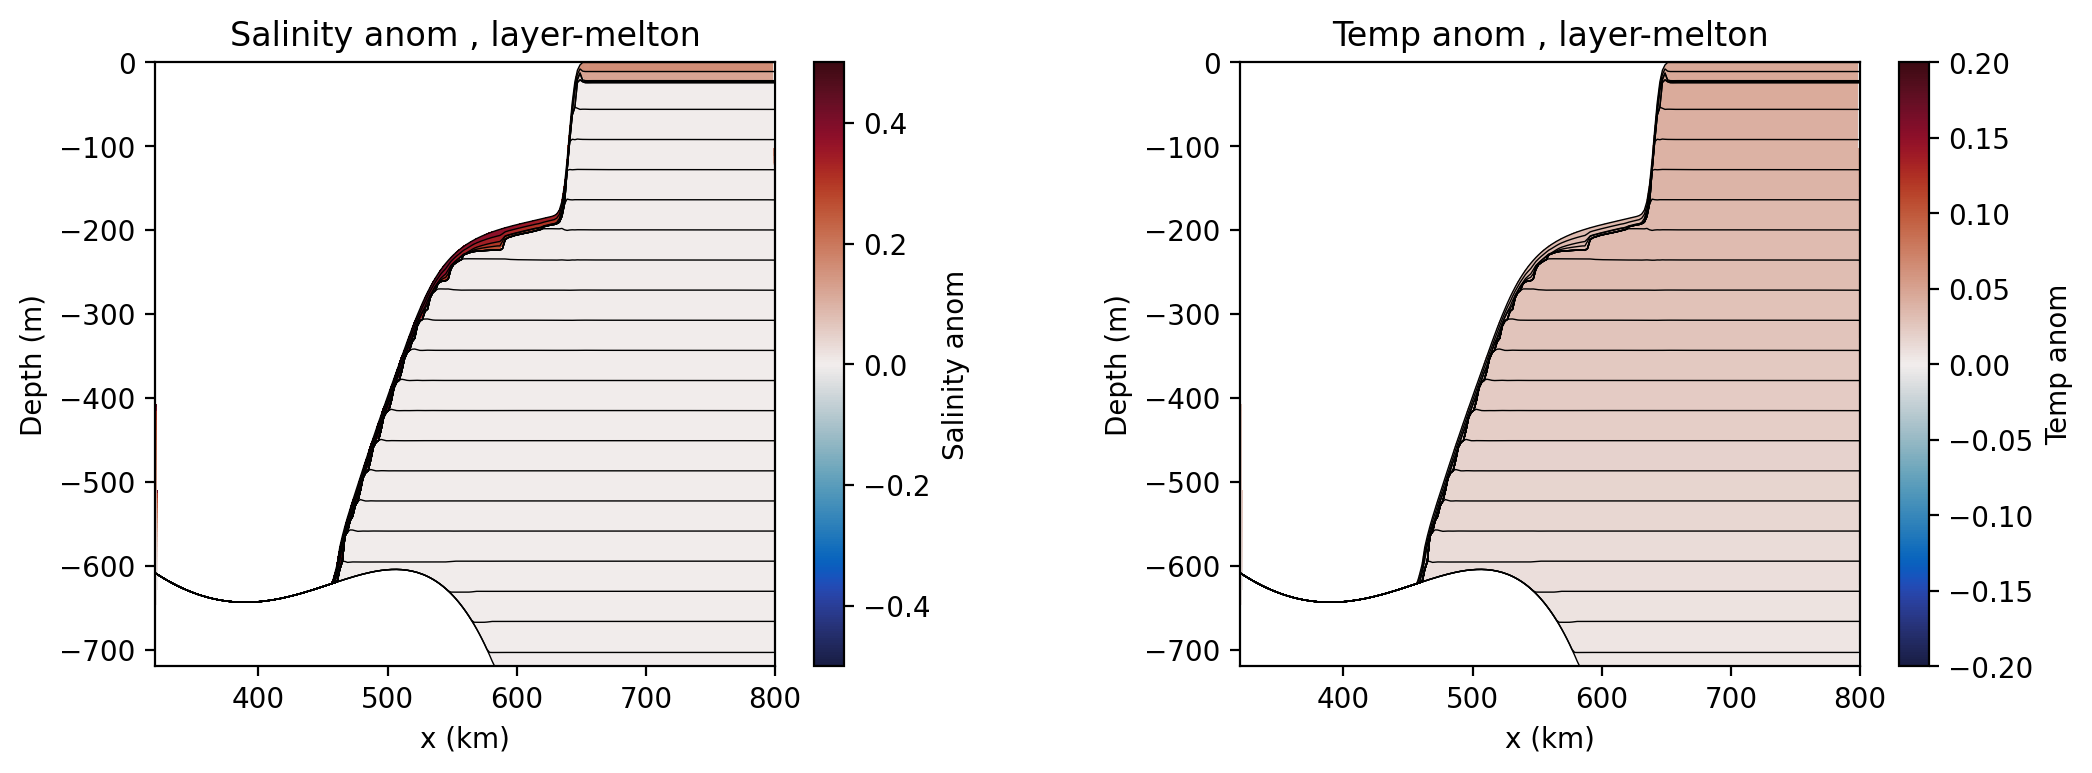

In [38]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,4),dpi = 200)
prog, ocean_static = open_files(label)
IC = open_IC(label)
x = 20
time = -1
ymax = 720
plot_IC = False

plot(axes[0],x,time,0,prog.salt - IC.Salt.values,"Salinity anom",-0.5,0.5,cm.cm.balance,ymax)
plot(axes[1],x,time,0,prog.temp - IC.Temp.values,"Temp anom",-0.2,0.2,cm.cm.balance,ymax)

# print('Old')
# label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile'
# prog, ocean_static = open_files(label)
# IC = open_IC(label)
# ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-720) + 33.8
# plot(axes[1],x,time,0,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell \n",-0.01,0.01,cm.cm.balance,ymax)

fig.subplots_adjust(wspace = 0.4)

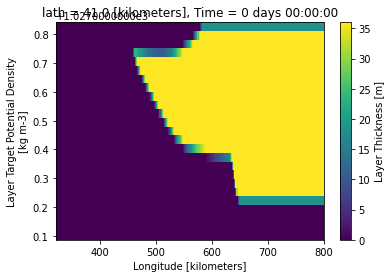

In [39]:
IC.h.isel(Time = 0, lath = 20).plot()

`TS_CONFIG = "fit"` so it's okay

Text(0.5, 1.0, 'new')

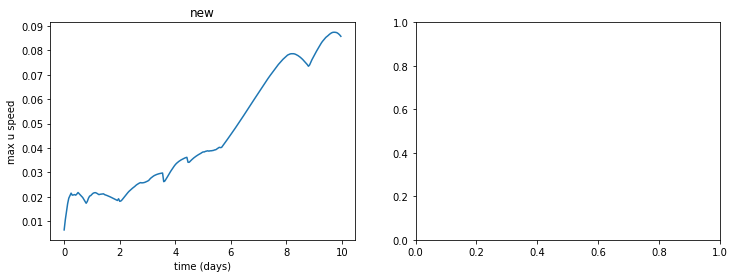

In [40]:
## Plot velocities
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))

prog, ocean_static = open_files(label)
axes[0].plot(np.arange(len(prog.Time))/24,np.abs(prog.u).max(['zl','yh','xq']))
axes[0].set_ylabel('max u speed')
axes[0].set_xlabel('time (days)')
axes[0].set_title('new')



Text(0.5, 1.0, 'layer-melton')

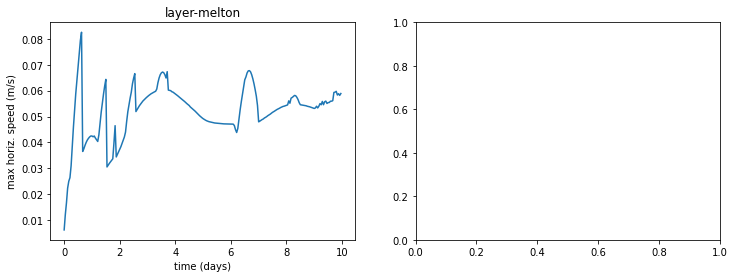

In [41]:
def find_speed(prog):
    # interpolate speeds to the same grid
    uo_interp = grid.interp(prog.u,'x',boundary='extend')
    vo_interp = grid.interp(prog.v,'y',boundary='extend')
    horiz_speed = np.sqrt(uo_interp**2+vo_interp**2)
    return horiz_speed

## Plot speed
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))
prog, ocean_static = open_files(label)
grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)# find horizontal speed
horiz_speed = find_speed(prog)

prog, ocean_static = open_files(label)
axes[0].plot(np.arange(len(prog.Time))/24,horiz_speed.max(['zl','yh','xh']))
axes[0].set_ylabel('max horiz. speed (m/s)')
axes[0].set_xlabel('time (days)')
axes[0].set_title(label)



New


/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_38732/1142033915.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)


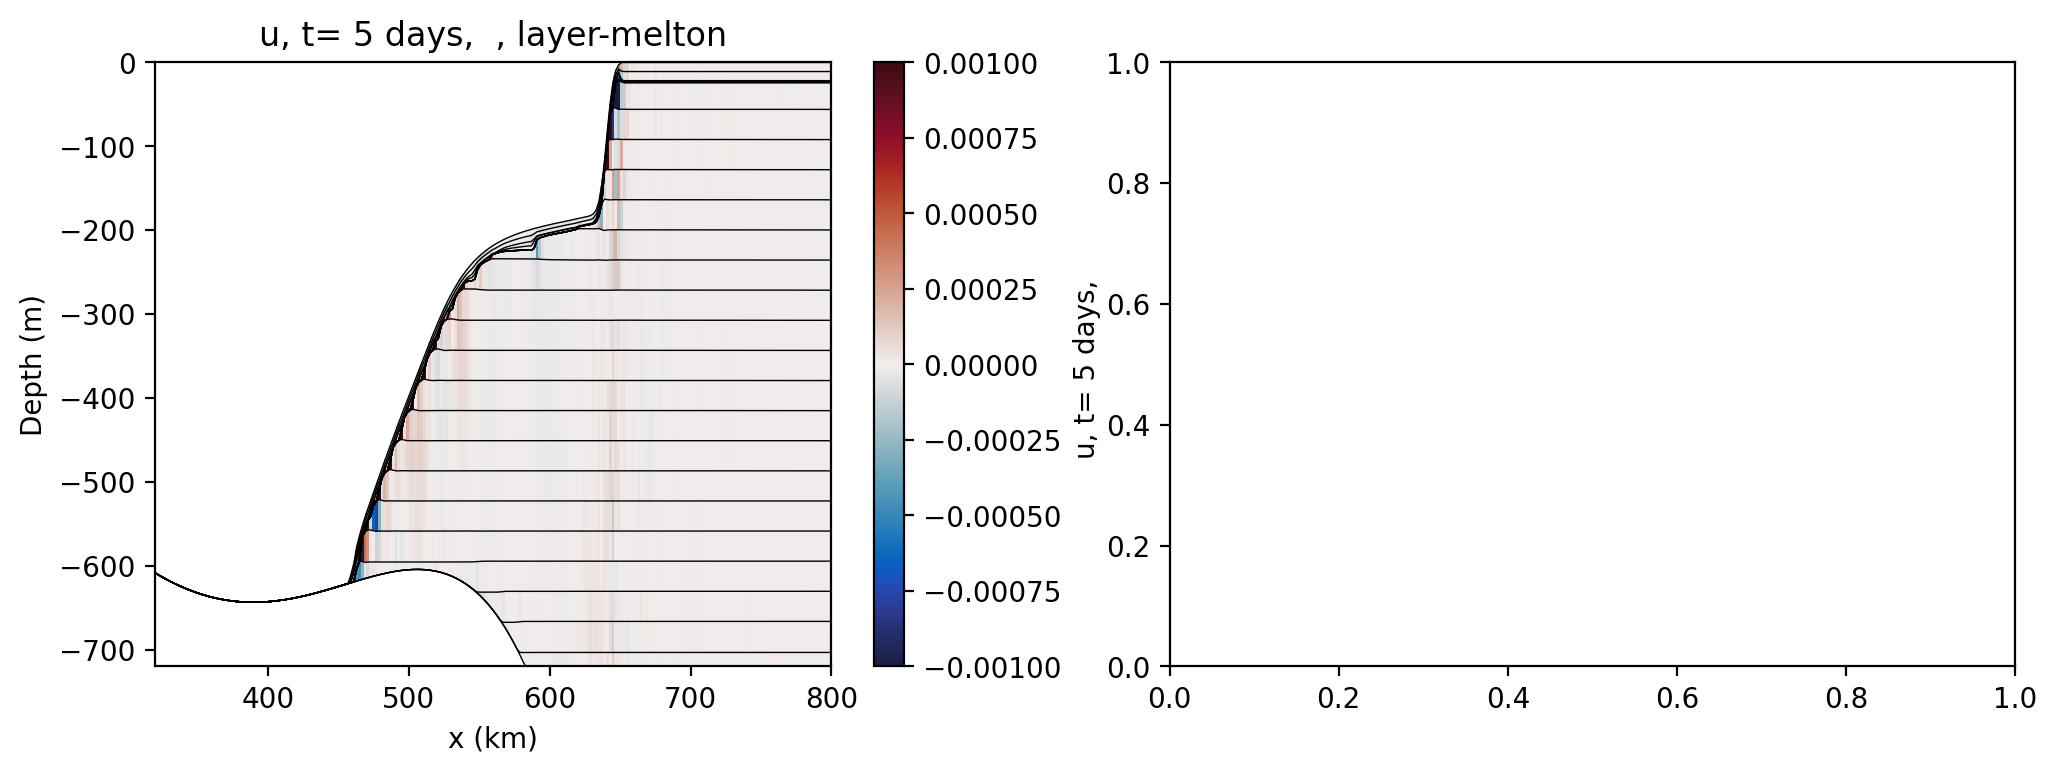

In [42]:

fig, axes = plt.subplots(ncols = 2, figsize = (12,4),dpi = 200)
prog, ocean_static = open_files(label)
x = 20
time = -1
ymax = 720
print('New')
plot_IC = False

plot(axes[0],x,time,0,prog.u,"u, t= 5 days, ",-1e-3,1e-3,cm.cm.balance,ymax)

# print('Old')
# label = 'sigmashelfz-ISOMIPtopo-shelf-tsconfigfile'
# prog, ocean_static = open_files(label)
# IC = open_IC(label)
# plot(axes[1],x,time,0,prog.u,"u, t= 1h,",-0.0001,0.0001,cm.cm.balance,ymax)

# fig.subplots_adjust(wspace = 0.4)

In [43]:
ice = xr.open_dataset('ice.nc')

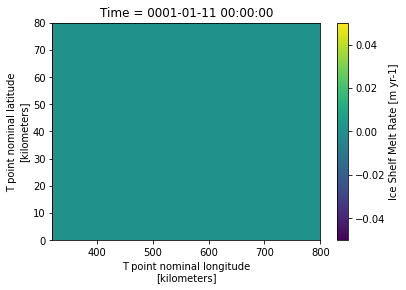

In [44]:
ice.melt_rate.isel(Time = -1).plot()

In [45]:
ice

<xarray.Dataset>
Dimensions:          (xT: 240, yT: 40, Time: 240, xB: 241, yB: 41)
Coordinates:
  * xT               (xT) float64 321.0 323.0 325.0 327.0 ... 795.0 797.0 799.0
  * yT               (yT) float64 1.0 3.0 5.0 7.0 9.0 ... 73.0 75.0 77.0 79.0
  * Time             (Time) object 0001-01-01 01:00:00 ... 0001-01-11 00:00:00
  * xB               (xB) float64 320.0 322.0 324.0 326.0 ... 796.0 798.0 800.0
  * yB               (yB) float64 0.0 2.0 4.0 6.0 8.0 ... 74.0 76.0 78.0 80.0
Data variables: (12/15)
    area_shelf_h     (Time, yT, xT) float32 ...
    shelf_mass       (Time, yT, xT) float32 ...
    h_shelf          (Time, yT, xT) float32 ...
    mass_flux        (Time, yT, xT) float32 ...
    melt_rate        (Time, yT, xT) float32 ...
    thermal_driving  (Time, yT, xT) float32 ...
    ...               ...
    v_ml             (Time, yB, xT) float32 ...
    exch_vel_s       (Time, yT, xT) float32 ...
    exch_vel_t       (Time, yT, xT) float32 ...
    tfreeze          (Time, yT, xT) float32 ...
    tflux_shelf      (Time, yT, xT) float32 ...
    ustar_shelf      (Time, yT, xT) float32 ...
Attributes:
    filename:   ice.nc
    title:      GOLD Experiment
    grid_type:  regular
    grid_tile:  N/A

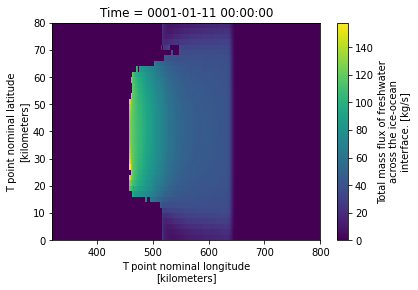

In [21]:
ice.mass_flux.isel(Time = -1).plot()

In [22]:
ocean_geometry = xr.open_dataset('ocean_geometry.nc')

In [23]:
prog.h

<xarray.DataArray 'h' (Time: 240, zl: 25, yh: 40, xh: 240)>
[57600000 values with dtype=float64]
Coordinates:
  * yh       (yh) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 71.0 73.0 75.0 77.0 79.0
  * zl       (zl) float64 1.027e+03 1.027e+03 1.027e+03 ... 1.028e+03 1.028e+03
  * Time     (Time) object 0001-01-01 01:00:00 ... 0001-01-11 00:00:00
  * xh       (xh) float64 321.0 323.0 325.0 327.0 ... 793.0 795.0 797.0 799.0
Attributes:
    long_name:     Layer Thickness
    units:         m
    cell_methods:  area:mean zl:sum yh:mean xh:mean time: point

In [24]:
s_to_year = 3600*24*365

Text(0.5, 1.0, 'Melt rate (m/year)')

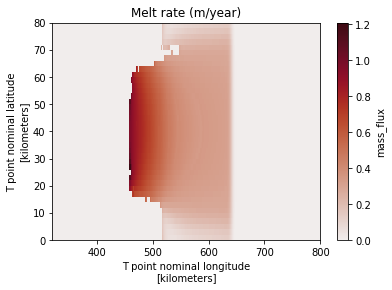

In [25]:
(ice.mass_flux.isel(Time = -1)/1030/(2000)**2*s_to_year).plot(cmap = cm.cm.amp) #dyt = dxt = 2000 m mass = rho * h * area
plt.title('Melt rate (m/year)')

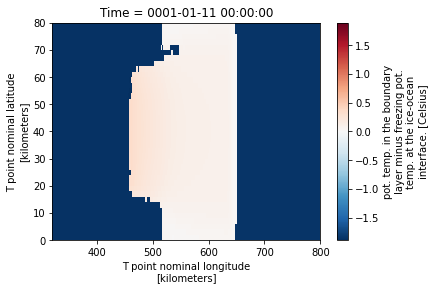

In [26]:
ice.thermal_driving.isel(Time = -1).plot()

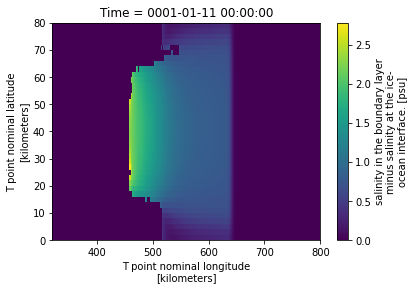

In [27]:
ice.haline_driving.isel(Time = -1).plot()

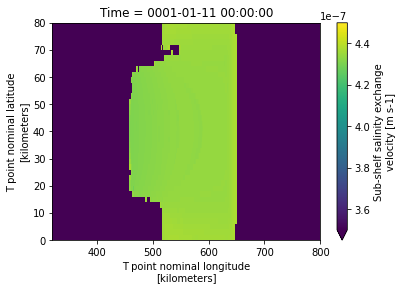

In [28]:
ice.exch_vel_s.isel(Time = -1).plot(vmin = 3.5e-7,vmax = 4.5e-7)

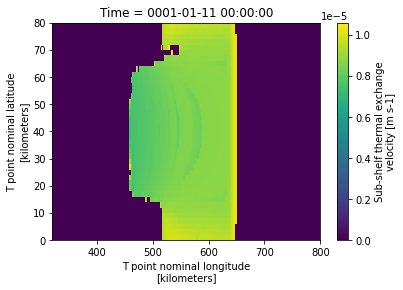

In [29]:
ice.exch_vel_t.isel(Time = -1).plot()

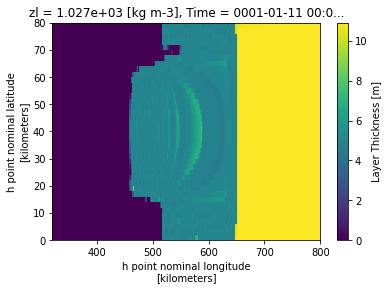

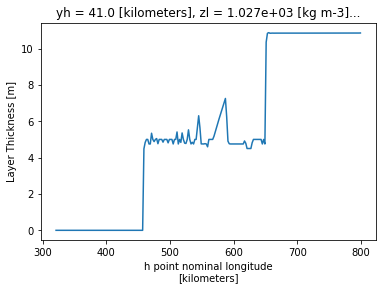

In [30]:
prog.h.isel(Time = -1, zl = 0).plot()
plt.show()
prog.h.isel(Time = -1, zl = 0,yh = 20).plot()

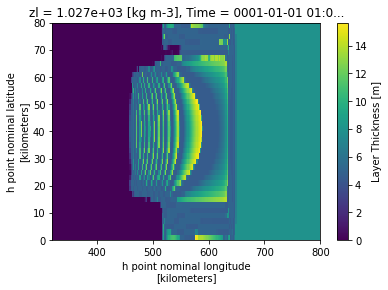

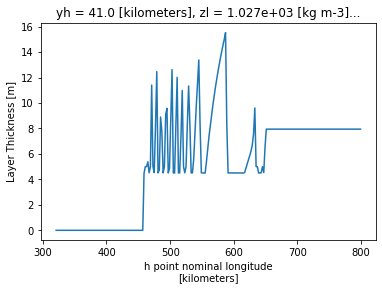

In [31]:
prog.h.isel(Time = 0, zl = 0).plot()
plt.show()
prog.h.isel(Time = 0, zl = 0,yh = 20).plot()

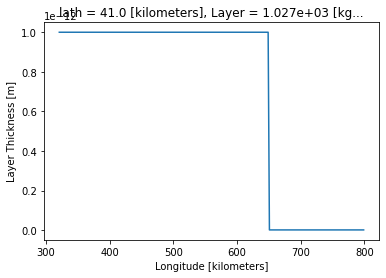

In [32]:
IC.h.isel(Time = 0, Layer = 0, lath = 20).plot()

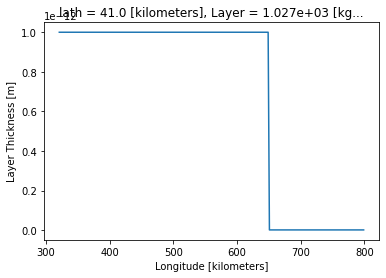

In [143]:
IC.h.isel(Time = 0, Layer = 2, lath = 20).plot()

## Plot viscous Obukhov coefficient

$L^+ = \frac{-u_*^4}{\nu k B_b} $

k = 0.41

$\nu$ = kv_molec = 1.95e-6

$B_b^T = \gamma_Tu_*g\frac{d\rho}{\rho_0dT}\Delta T$

Some parts of below plot negative so can't just use thermal forcing. How to use melt?

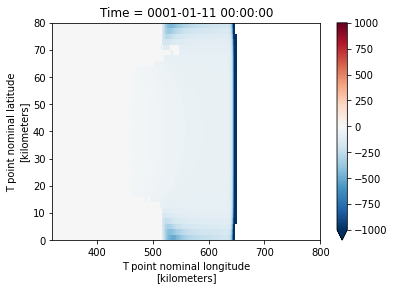

In [147]:
tt = -1

Gamma_T_3EQ = 2.2e-2
vk = 0.41
kv_molec = 1.95e-6
g = 9.81
drho_dT = 0.805876093   #[kg m-3 PSU-1]
rho_0 = 1028
thermal_forcing = ice.thermal_driving.isel(Time = tt)
ustar = ice.ustar_shelf.isel(Time = tt)

B_b = Gamma_T_3EQ*ustar*g/rho_0*drho_dT*thermal_forcing
Lplus = -ustar**4/(vk*kv_molec*B_b)
Lplus.plot(vmax = 1000)

In [145]:
prog.temp.isel

<bound method DataArray.isel of <xarray.DataArray 'temp' (Time: 240, zl: 25, yh: 40, xh: 240)>
[57600000 values with dtype=float32]
Coordinates:
  * yh       (yh) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 71.0 73.0 75.0 77.0 79.0
  * zl       (zl) float64 1.027e+03 1.027e+03 1.027e+03 ... 1.028e+03 1.028e+03
  * Time     (Time) object 0001-01-01 01:00:00 ... 0001-01-11 00:00:00
  * xh       (xh) float64 321.0 323.0 325.0 327.0 ... 793.0 795.0 797.0 799.0
Attributes:
    long_name:     Potential Temperature
    units:         degC
    cell_methods:  area:mean zl:mean yh:mean xh:mean time: point>

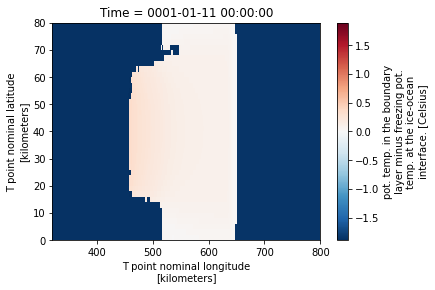

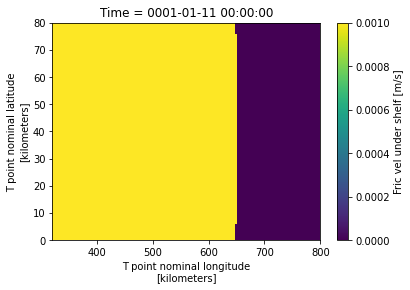

In [146]:
ice.thermal_driving.isel(Time = -1).plot()

plt.show()

ice.ustar_shelf.isel(Time = -1).plot()


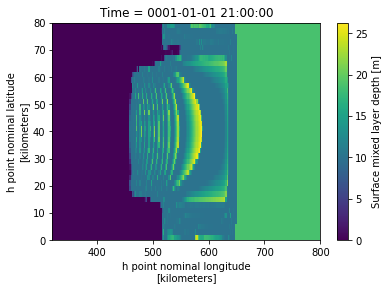

In [52]:
prog = xr.open_dataset('prog.nc')
prog.h_ML.isel(Time = 20).plot()

In [53]:
!cat MOM_override

! Blank file in which we can put "overrides" for parameters
#override DAYMAX = 5
#override SHELF_THERMO = True
#override SHELF_THREE_EQN = True

#override SMAGORINSKY_KH = False
#override BIHARMONIC = False
#override KH = 6.0  ! back. horiz. visc.
#override KHTR = 1.0    ! back. horiz. diff.
#override KD = 5.0E-5     ! back. diapycnal diff.
#override KV = 1.0E-3     ! back. diapycnal visc.

! MIXED LAYER
#override BULKMIXEDLAYER = True
#override BULK_RI_ML = 0.05 ! 0.25

! MH MOM-input/override params
#override FRAZIL = True
!#override T_REF = -0.5
#override FIXED_DEPTH_LOTW_ML = True
#override LOTW_VISCOUS_ML_FLOOR = True
#override DYNAMIC_SURFACE_PRESSURE = True
#override COL_THICK_MELT_THRESHOLD = 1.0
#override SHELF_INSULATOR = True

! test
#override COORD_CONFIG = "ts_range"
#override T_REF = -1.9
#override S_REF = 34.0                    !   [PSU] default = 35.0
#override TS_RANGE_S_LIGHT = 33.8         !   [PSU] default = 35.0
#override TS_RANGE_S_DENSE = 34.55         !   [PSU]